<a href="https://colab.research.google.com/github/ventali/QLoRA/blob/main/QLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.5 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-v0.1"  # Or any Hugging Face LLM

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="bfloat16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [7]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


In [14]:
from datasets import Dataset

# Expanded sample quotes from Oscar Wilde
quotes = [
    {"quote": "Be yourself; everyone else is already taken."},
    {"quote": "I can resist everything except temptation."},
    {"quote": "To live is the rarest thing in the world. Most people exist, that is all."},
    {"quote": "The only way to get rid of temptation is to yield to it."},
    {"quote": "We are all in the gutter, but some of us are looking at the stars."},
    {"quote": "Experience is simply the name we give our mistakes."},
    {"quote": "Always forgive your enemies; nothing annoys them so much."},
    {"quote": "A cynic is a man who knows the price of everything and the value of nothing."},
    {"quote": "The truth is rarely pure and never simple."},
    {"quote": "Women are made to be loved, not understood."},
    {"quote": "Life is far too important a thing ever to talk seriously about."},
    {"quote": "I am so clever that sometimes I don't understand a single word of what I am saying."},
    {"quote": "Every saint has a past, and every sinner has a future."},
    {"quote": "The only thing to do with good advice is to pass it on. It is never of any use to oneself."},
    {"quote": "I don't want to go to heaven. None of my friends are there."},
    {"quote": "Morality is simply the attitude we adopt towards people we personally dislike."},
    {"quote": "The old believe everything; the middle-aged suspect everything; the young know everything."},
    {"quote": "Some cause happiness wherever they go; others whenever they go."},
    {"quote": "No man is rich enough to buy back his past."},
    {"quote": "A man’s face is his autobiography. A woman’s face is her work of fiction."},
    {"quote": "I have nothing to declare except my genius."},
    {"quote": "Fashion is a form of ugliness so intolerable that we have to alter it every six months."},
    {"quote": "The books that the world calls immoral are books that show the world its own shame."},
    {"quote": "Education is an admirable thing, but it is well to remember that nothing worth knowing can be taught."},
    {"quote": "Man is least himself when he talks in his own person. Give him a mask, and he will tell you the truth."},
    {"quote": "The only difference between the saint and the sinner is that every saint has a past, and every sinner has a future."},
    {"quote": "We live in an age when unnecessary things are our only necessities."},
    {"quote": "I never travel without my diary. One should always have something sensational to read in the train."},
    {"quote": "A little sincerity is a dangerous thing, and a great deal of it is absolutely fatal."},
    {"quote": "It is what you read when you don't have to that determines what you will be when you can't help it."},
    {"quote": "There is only one thing in the world worse than being talked about, and that is not being talked about."},
    {"quote": "Arguments are extremely vulgar, for everyone in good society holds exactly the same opinions."},
    {"quote": "Seriousness is the only refuge of the shallow."},
    {"quote": "Nothing can cure the soul but the senses, just as nothing can cure the senses but the soul."},
    {"quote": "The world is a stage, but the play is badly cast."},
    {"quote": "In matters of grave importance, style, not sincerity, is the vital thing."},
    {"quote": "There is no sin except stupidity."},
    {"quote": "It is absurd to divide people into good and bad. People are either charming or tedious."},
    {"quote": "The only way to behave to a woman is to make love to her if she is pretty and to someone else if she is plain."},
    {"quote": "I like men who have a future and women who have a past."},
    {"quote": "When the gods wish to punish us, they answer our prayers."},
    {"quote": "One should always be a little improbable."},
    {"quote": "No good deed goes unpunished."},
    {"quote": "There are only two kinds of people who are really fascinating: people who know absolutely everything, and people who know absolutely nothing."},
    {"quote": "You can never be overdressed or overeducated."},
    {"quote": "Ordinary riches can be stolen, real riches cannot. In your soul are infinitely precious things that cannot be taken from you."},
    {"quote": "Hatred is blind, as well as love."},
    {"quote": "Ambition is the last refuge of the failure."},
    {"quote": "Work is the curse of the drinking classes."},
    {"quote": "Conscience and cowardice are really the same things."},
    {"quote": "How can a woman be expected to be happy with a man who insists on treating her as if she were a perfectly normal human being?"},
]

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(quotes)

# Tokenize the quotes
def tokenize(example):
    tokenized_example = tokenizer(example["quote"], truncation=True, padding="max_length", max_length=128)
    tokenized_example["labels"] = tokenized_example["input_ids"].copy() # Add labels column
    return tokenized_example

tokenized_dataset = dataset.map(tokenize)

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [19]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./qlora-output",
    per_device_train_batch_size=4, # Reduced batch size
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=2,
    save_strategy="epoch",
    optim="paged_adamw_8bit",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

trainer.train()

/tmp/ipython-input-19-3349374755.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
2,0.261300
4,4.628000
6,4.705200
8,0.434300
10,0.213400
12,0.179800


TrainOutput(global_step=12, training_loss=1.7370175023873646, metrics={'train_runtime': 64.8914, 'train_samples_per_second': 2.358, 'train_steps_per_second': 0.185, 'total_flos': 835931442511872.0, 'train_loss': 1.7370175023873646, 'epoch': 3.0})

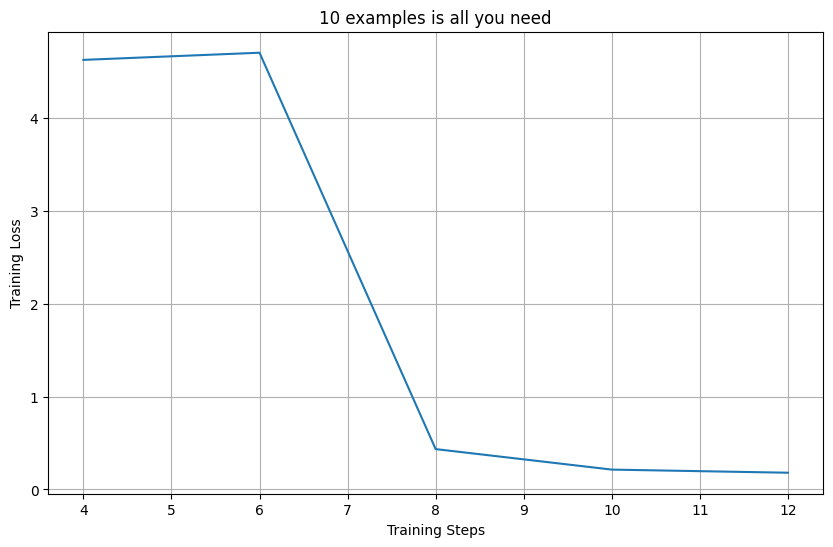

In [24]:
import matplotlib.pyplot as plt

# Extract training loss from the trainer.train() output
# Assuming the output is stored in a variable named 'train_output'
# If not, you might need to re-run the training cell and capture the output

# The training loss is typically logged at intervals defined by logging_steps
# We need to find the logged loss values in the trainer's logs or the returned metrics
# Based on the previous output, the final training loss is available in the metrics.
# However, to plot the loss over time, we need the logged losses at each logging step.
# The Trainer object stores the logs internally. Let's access them.

# If the trainer object is still available from the previous execution:
if 'trainer' in locals() and trainer.state.log_history:
    loss_history = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
    steps = [entry['step'] for entry in trainer.state.log_history if 'loss' in entry]

    if loss_history:
        plt.figure(figsize=(10, 6))
        plt.plot(steps[1:], loss_history[1:])
        plt.xlabel("Training Steps")
        plt.ylabel("Training Loss")
        plt.title("10 examples is all you need")
        plt.grid(True)
        plt.show()
    else:
        print("No loss history found in trainer logs.")
else:
    print("Trainer object not found or no log history available. Please ensure the training cell was run and the trainer object is accessible.")